In [1]:
import sys

import matplotlib.pyplot as plt

import numpy as np
import torch

sys.path.insert(0, "../")

%load_ext autoreload
%autoreload 2

/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import src
from src.functional.renderer import (
    ColoredRenderer,
    convert_vertices_to_mesh,
    fit_vertices_to_orthographic,
    get_vertex_visibility_mask,
    render_mesh_onto_image,
    SilhouetteRenderer,
    SilhouetteRendererPytorch3d,
    unproject_to_faces,
    unproject_to_vertices,
)

from src.datasets.datasets_common import UNNORMALIZE
from src.utils import img_utils

from src.functional.smpl import get_smpl_model
smpl_model = get_smpl_model()

from src.datasets.coco_eft import COCO_EFT
ds_train = COCO_EFT(is_train=False)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=32, shuffle=False)

for x in dl_train:
    break

img = UNNORMALIZE(x["img"])
shape_gt = x["smpl_shape"]
pose_gt = x["smpl_pose"]
cam_gt = x["parm_cam"]

gt_out = smpl_model(betas=shape_gt, body_pose=pose_gt[:, 3:], global_orient=pose_gt[:, :3], pose2rot=True)
verts_gt = gt_out.vertices
joints_gt = gt_out.joints

scale, trans = cam_gt[:, 0], cam_gt[:, 1:]

boxScale_o2n, bboxTopLeft, orig_shape, crop_shape = (
    x["bboxInfoScale"],
    x["bboxInfoTopLeft"],
    x["orig_shape"],
    x["crop_shape"],
)

bbox_verts = img_utils.convert_norm_points_to_bbox(
    verts_gt.cpu(),
    scale,
    trans,
    crop_shape,
)

faces = smpl_model.faces.astype(int)

d = dict(img=img, bbox_verts=bbox_verts, faces=faces)

/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643003845/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


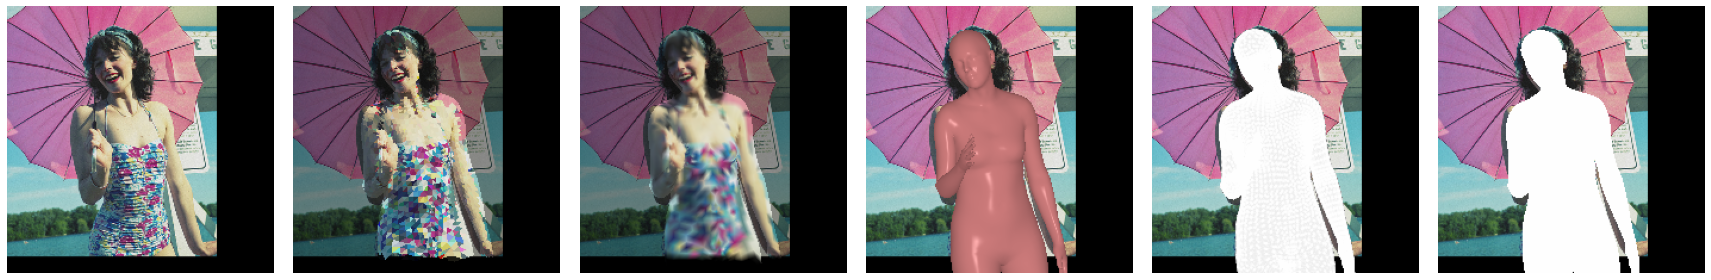

In [4]:
device = "cuda:1"
img = d["img"].clone().to(device)  # B x 3 x H x W
vertices = d["bbox_verts"].clone().to(device)  # B x N x 3
faces = d["faces"]  ### type: int64 (result of smpl_model.faces.astype(int))

torch.set_grad_enabled(False)

batch_size = img.size(0)
img_size = img.shape[-2:]

faces_batch = torch.tensor(faces.copy()).unsqueeze(0).repeat(batch_size, 1, 1).to(device)

### new version of "render onto image" - torch and batch-wise
img = img.permute(0, 2, 3, 1) / 255  # B x H x W x 3

colorbody_renderer = ColoredRenderer(img_size=img_size, device=device, specular_color=True, diffuse_color=True)
silh_renderer = SilhouetteRenderer(img_size=img_size, device=device)
silh_renderer_old = SilhouetteRendererPytorch3d(img_size=img_size, device=device)
texel_renderer = ColoredRenderer(img_size=img_size, device=device)

### for orthographic projection, body should be moved a bit away from the camera
vertices = fit_vertices_to_orthographic(vertices, img_size)

meshes = convert_vertices_to_mesh(vertices, faces_batch)
render_images = colorbody_renderer(meshes)
silh_images = silh_renderer(meshes.clone())
silh_images_old = silh_renderer_old(meshes.clone())

### unproject img as texture to faces
meshes_img = meshes.clone()
meshes_img.textures = unproject_to_faces(img, meshes_img, img_size)
img_to_faces = texel_renderer(meshes_img)

### to verts
verts_rgb = unproject_to_vertices(img.permute(0, 3, 1, 2), vertices)
meshes = convert_vertices_to_mesh(vertices, faces_batch, verts_rgb_colors=verts_rgb)
img_to_verts = texel_renderer(meshes)


blend_images = render_mesh_onto_image(img, render_images)
blend_images_silh = render_mesh_onto_image(img, silh_images[..., None])
blend_images_silh_old = render_mesh_onto_image(img, silh_images_old[..., None])
blend_images__to_faces = render_mesh_onto_image(img * 0.6, img_to_faces)
blend_images__to_verts = render_mesh_onto_image(img * 0.6, img_to_verts)

images_to_plot = 1
images = [img, blend_images__to_faces, blend_images__to_verts, blend_images, blend_images_silh_old, blend_images_silh]
fig, ax = plt.subplots(images_to_plot, len(images), figsize=(len(images) * 4, images_to_plot * 4))
ax = ax.flatten()

for i in range(images_to_plot):
    for j, images_ in enumerate(images):
        k = i * images_to_plot + j
        ax[k].imshow(images_[i].cpu())

for axis in ax.flatten():
    axis.set_axis_off()
fig.tight_layout()
fig.subplots_adjust()
fig.patch.set_facecolor("white")

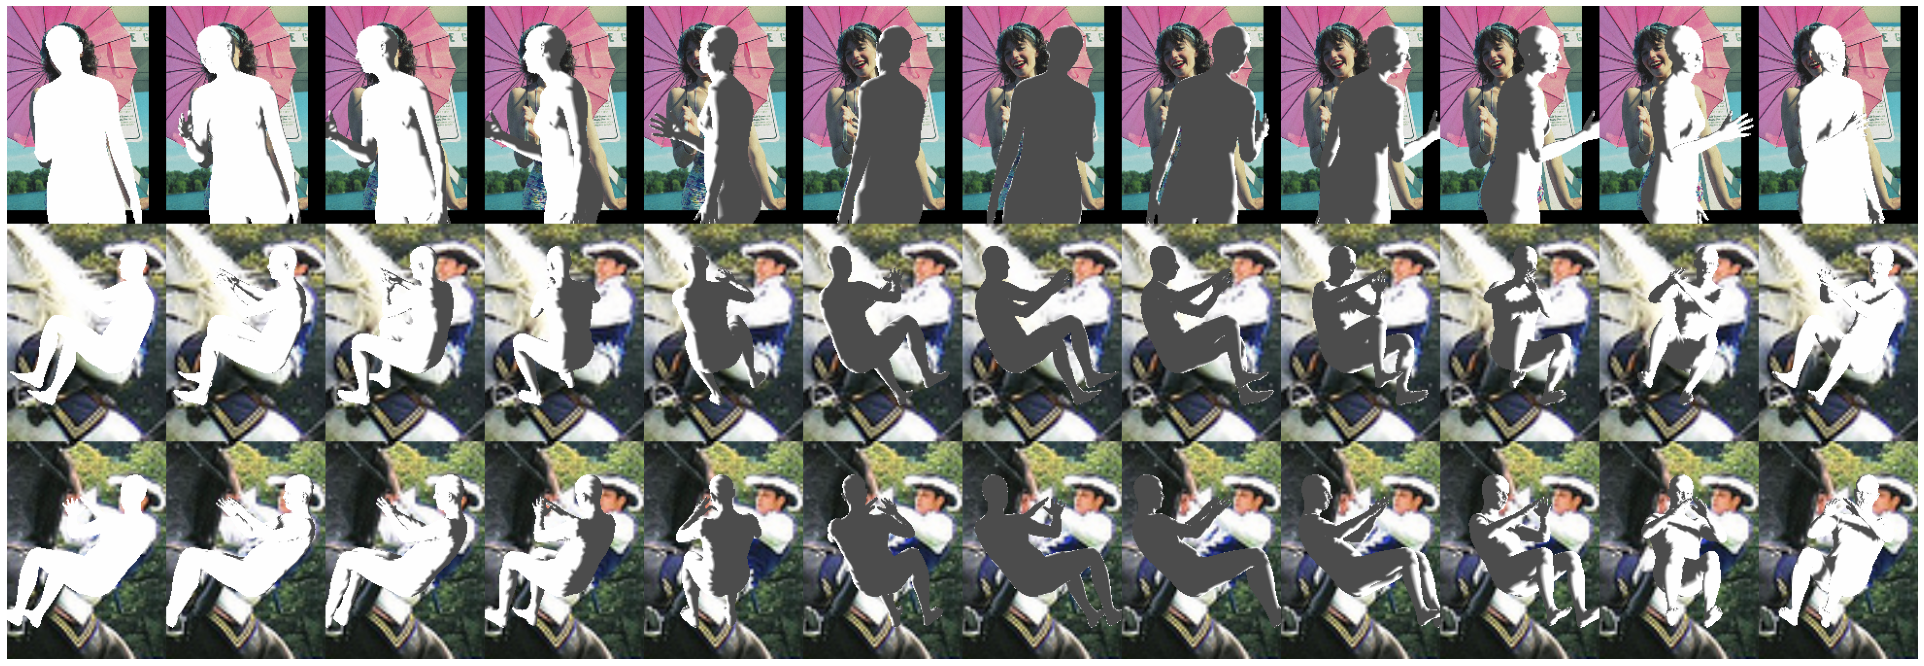

In [5]:
device = "cuda:1"
img = d["img"].clone().to(device)  # B x 3 x H x W
vertices = d["bbox_verts"].clone().to(device)  # B x N x 3
faces = d["faces"]  ### type: int64 (result of smpl_model.faces.astype(int))

torch.set_grad_enabled(False)

batch_size = img.size(0)
img_size = img.shape[-2:]

faces_batch = torch.tensor(faces.copy()).unsqueeze(0).repeat(batch_size, 1, 1).to(device)

### new version of "render onto image" - torch and batch-wise
img = img.permute(0, 2, 3, 1) / 255  # B x H x W x 3

colorbody_renderer = ColoredRenderer(img_size=img_size, device=device, specular_color=True, diffuse_color=True)

import math

import pytorch3d.renderer

device = "cuda:1"
batch_size_custom = 3
img = d["img"].clone().to(device)[:batch_size_custom]  # B x 3 x H x W
img_size = img.shape[-2:]
img = img.permute(0, 2, 3, 1) / 255  # B x H x W x 3
vertices = d["bbox_verts"][:batch_size_custom].clone().to(device)  # B x N x 3
faces = d["faces"]  ### type: int64 (result of smpl_model.faces.astype(int))

batch_size = img.size(0)
faces_batch = torch.tensor(faces.copy()).unsqueeze(0).repeat(batch_size, 1, 1).to(device)

torch.set_grad_enabled(False)



### get the mask
vertices = fit_vertices_to_orthographic(vertices, img_size)
meshes = convert_vertices_to_mesh(vertices, faces_batch)
colorbody_renderer = ColoredRenderer(img_size=img_size, device=device)

visibility_mask = get_vertex_visibility_mask(meshes, colorbody_renderer.cameras, img_size)
verts_rgb_colors = torch.ones_like(vertices).view(-1, 3) * 0.3
verts_rgb_colors[visibility_mask > 0.5] = 1.0
verts_rgb_colors = verts_rgb_colors.view(vertices.size())

angles = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]
rot_images = []
for angle in angles:

    c = math.cos(angle / 360 * 2 * math.pi)
    s = math.sin(angle / 360 * 2 * math.pi)

    vertices_ = vertices.clone()
    verts_x = vertices_[:, :, 0] * c - (vertices_[:, :, 2] - 10) * s
    verts_z = vertices_[:, :, 0] * s + (vertices_[:, :, 2] - 10) * c
    vertices_[:, :, 0] = verts_x
    vertices_[:, :, 2] = verts_z + 10

    meshes = convert_vertices_to_mesh(vertices_, faces_batch)
    textures = pytorch3d.renderer.TexturesVertex(verts_features=verts_rgb_colors)
    meshes.textures = textures

    render_images = colorbody_renderer(meshes)
    blend_images = render_mesh_onto_image(img, render_images)
    blend_images = torch.cat(list(blend_images), dim=0)
    rot_images.append(blend_images.cpu()[:, 30:-30])
    
rot_images = torch.cat(rot_images, dim=1)
fig, ax = plt.subplots(1, 1, figsize=(len(angles) * 4, batch_size * 4))
ax.imshow(rot_images)
ax.set_axis_off()

# test "close-far" lady textures


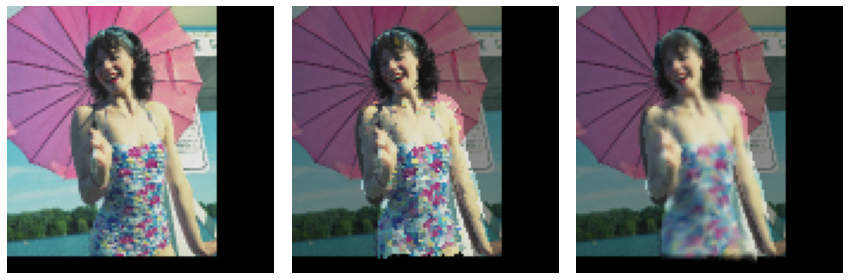

In [6]:
import src
from src.functional.renderer import (
    ColoredRenderer,
    convert_vertices_to_mesh,
    fit_vertices_to_orthographic,
    get_vertex_visibility_mask,
    render_mesh_onto_image,
    SilhouetteRenderer,
    SilhouetteRendererPytorch3d,
    unproject_to_faces,
    unproject_to_vertices,
)

device = "cuda:1"
img = d["img"].clone().to(device)  # B x 3 x H x W
vertices = d["bbox_verts"].clone().to(device)  # B x N x 3
faces = d["faces"]  ### type: int64 (result of smpl_model.faces.astype(int))

pad = 0
################
import torchvision

img = torchvision.transforms.Resize((112, 112))(img)
pad = (224 - 112) // 2
img = torch.nn.functional.pad(img, (pad, pad, pad, pad))
vertices[:, :, :2] = vertices[:, :, :2] / 2 + pad
################
t, b, l, r = pad, img.shape[-1] - pad, pad, img.shape[-1] - pad

torch.set_grad_enabled(False)

batch_size = img.size(0)
img_size = img.shape[-2:]

faces_batch = torch.tensor(faces.copy()).unsqueeze(0).repeat(batch_size, 1, 1).to(device)

### new version of "render onto image" - torch and batch-wise
img = img.permute(0, 2, 3, 1) / 255  # B x H x W x 3

colorbody_renderer = ColoredRenderer(img_size=img_size, device=device, specular_color=True, diffuse_color=True)
silh_renderer = SilhouetteRenderer(img_size=img_size, device=device)
silh_renderer_old = SilhouetteRendererPytorch3d(img_size=img_size, device=device)
texel_renderer = ColoredRenderer(img_size=img_size, device=device)

### for orthographic projection, body should be moved a bit away from the camera
vertices = fit_vertices_to_orthographic(vertices, img_size)

meshes = convert_vertices_to_mesh(vertices, faces_batch)
render_images = colorbody_renderer(meshes)
silh_images = silh_renderer(meshes.clone())
silh_images_old = silh_renderer_old(meshes.clone())

### unproject img as texture to faces
meshes_img = meshes.clone()
meshes_img.textures = unproject_to_faces(img, meshes_img, img_size)
img_to_faces = texel_renderer(meshes_img)

### to verts
verts_rgb = unproject_to_vertices(img.permute(0, 3, 1, 2), vertices)
meshes = convert_vertices_to_mesh(vertices, faces_batch, verts_rgb_colors=verts_rgb)
img_to_verts = texel_renderer(meshes)


blend_images = render_mesh_onto_image(img, render_images)
blend_images_silh = render_mesh_onto_image(img, silh_images[..., None])
blend_images_silh_old = render_mesh_onto_image(img, silh_images_old[..., None])
blend_images__to_faces = render_mesh_onto_image(img * 0.6, img_to_faces)
blend_images__to_verts = render_mesh_onto_image(img * 0.6, img_to_verts)

images_to_plot = 1
images = [
    img,
    blend_images__to_faces,
    blend_images__to_verts,
]  # , blend_images, blend_images_silh_old, blend_images_silh]
fig, ax = plt.subplots(images_to_plot, len(images), figsize=(len(images) * 4, images_to_plot * 4))
ax = ax.flatten()

for i in range(images_to_plot):
    for j, images_ in enumerate(images):
        k = i * images_to_plot + j
        ax[k].imshow(images_[i].cpu()[t:b, l:r])

for axis in ax.flatten():
    axis.set_axis_off()
fig.tight_layout()
fig.subplots_adjust()
fig.patch.set_facecolor("white")